In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
import torch
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.pyplot as plt
import matplotlib as mlp
from IPython.display import Image, clear_output

In [15]:
%%time

!git clone https://github.com/ultralytics/yolov5
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 11290, done.
remote: Total 11290 (delta 0), reused 0 (delta 0), pack-reused 11290
Receiving objects: 100% (11290/11290), 11.20 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (7808/7808), done.
     |████████████████████████████████| 106 kB 16.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp38-cp38-linux_x86_64.whl size=311537 sha256=eaa69b261832b22b01f5d36f6e73e8e8de870c91a9cb6ba308cff609b7924842
  Stored in directory: /opt/ml/.cache/pip/wheels/dd/e2/43/3e93cd653b3346b3d702bb0509bc611189f95d60407bff1484
Successfully built pycocotools
CPU times: user 216 ms, sys: 88 ms, total: 304 ms
Wall time: 23.2 s


In [25]:
TRAIN_PATH = '/opt/ml/car_detection_data/training_images/'
TEST_PATH = '/opt/ml/car_detection_data/testing_images/'

In [12]:
train = pd.read_csv('./train_solution_bounding_boxes (1).csv')
train.rename(columns={'image':'image_id'}, inplace=True)
train['image_id'] = train['image_id'].apply(lambda x : x.split('.')[0])
train.head()

,image_id,xmin,ymin,xmax,ymax
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422


In [10]:
img_h, img_w, num_channels = (380, 676, 3)

In [14]:
train['x_center'] = (train['xmin'] + train['xmax']) / 2
train['y_center'] = (train['ymin'] + train['ymax']) / 2
train['w'] = train['xmax'] - train['xmin']
train['h'] = train['ymax'] - train['ymin']
train['classes'] = 0
train['x_center'] = train['x_center'] / img_w
train['y_center'] = train['y_center'] / img_h
train['w'] = train['w'] / img_w
train['h'] = train['h'] / img_h

train.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [26]:
index = list(set(train['image_id']))
image = random.choice(index)
print(f'Image ID : {image}')
img = cv2.imread(f'{TRAIN_PATH}{image}.jpg')
img.shape

Image ID : vid_4_21160


(380, 676, 3)

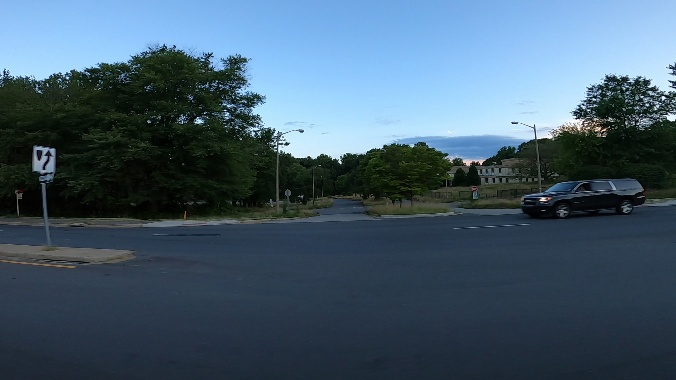

In [27]:
Image(filename=f'{TRAIN_PATH}{image}.jpg')

# Training

In [32]:
if True:
  for fold in [0]:
    val_index = index[len(index)*fold//5 : len(index)*(fold+1)//5]
    for name, mini in tqdm(train.groupby('image_id')):
      if name in val_index:
        path2save = 'val2017/'
      else:
        path2save = 'train2017/'
      if not os.path.exists(f'/opt/ml/convertor/fold{fold}/labels/{path2save}'):
        os.makedirs(f'/opt/ml/convertor/fold{fold}/labels/{path2save}')
      with open(f'/opt/ml/convertor/fold{fold}/labels/{path2save}{name}.txt', 'w+') as f:
        row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
          text = ' '.join(row[j])
          f.write(text)
          f.write('\n')
      if not os.path.exists(f'/opt/ml/convertor/fold{fold}/images/{path2save}'):
        os.makedirs(f'/opt/ml/convertor/fold{fold}/images/{path2save}')
      sh.copy(f'{TRAIN_PATH}{name}.jpg', f'/opt/ml/convertor/fold{fold}/images/{path2save}/{name}.jpg')

# Prediction

In [99]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /opt/ml/car_detection_data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/opt/ml/car_detection_data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-32-gc13d4ce torch 1.11.0+cu102 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/175 /opt/ml/car_detection_data/testing_images/vid_5_25100.jpg: 416x704 Done. (0.007s)
image 2/175 /opt/ml/car_detection_data/testing_images/vid_5_25120.jpg: 416x704 Done. (0.006s)
image 3/175 /opt/ml/car_detection_data/testing_images/vid_5_25140.jpg: 416x704 Done. (0.006s)
image 4/175 /opt/ml/car_detection_data/testing_images/vid_5_25160.jpg: 4

In [100]:
predicted_files = []
for dirpath, dirnames, filenames in os.walk('./yolov5/runs/detect/exp6'):
  predicted_files.extend(filenames)

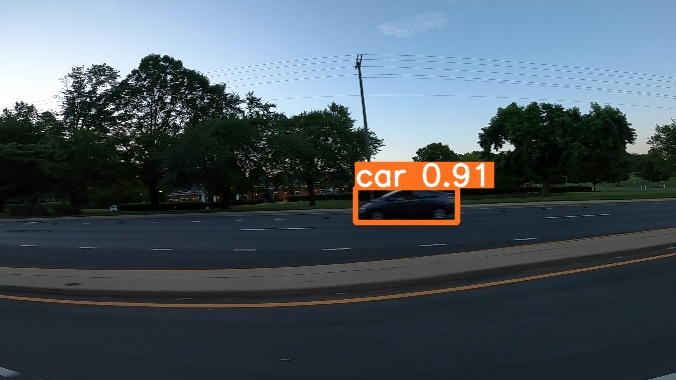

In [113]:
Image(filename=f'./yolov5/runs/detect/exp6/{random.choice(predicted_files)}')

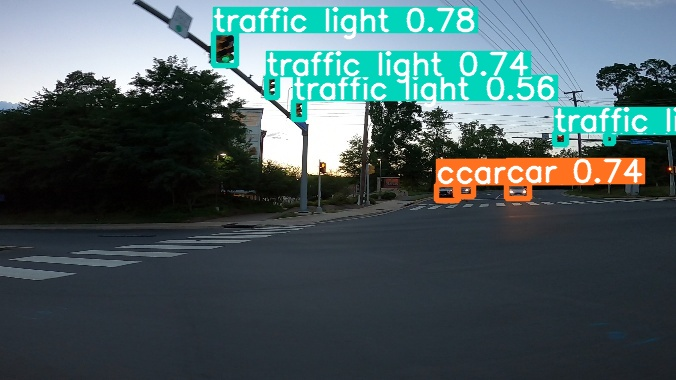

In [116]:
Image(filename=f'./yolov5/runs/detect/exp6/{random.choice(predicted_files)}')

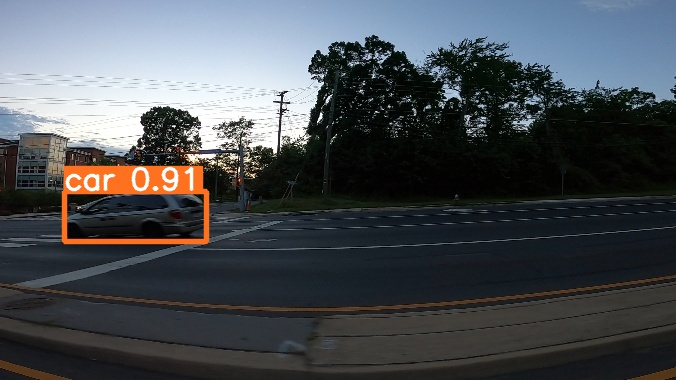

In [118]:
Image(filename=f'./yolov5/runs/detect/exp6/{random.choice(predicted_files)}')

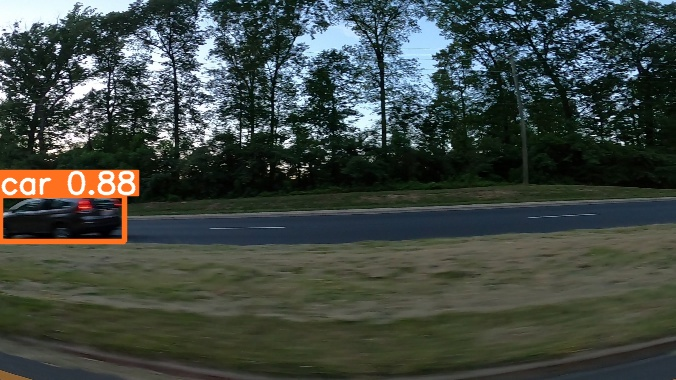

In [123]:
Image(filename=f'./yolov5/runs/detect/exp6/{random.choice(predicted_files)}')